In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import matplotlib

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histominute'
res = requests.get(endpoint + '?fsym=EUR&tsym=USD&limit=500')
data = json.loads(res.content)['Data']

for element in data:

    element.pop('conversionType', None)
    element.pop('conversionSymbol', None)

hist = pd.DataFrame(data)
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')

In [3]:
'''
# 10 digit format to Y-M-D H:M:S

from datetime import datetime
ts = int("1284101485")
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

'''

target_col = 'close'
# hist.head(5)

In [4]:
def train_test_split(df, test_size=0.2):
    
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [5]:
train, test = train_test_split(hist, test_size=0.2)

In [6]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);
    fig.show() # to see collected data & predicted graph

<ipython-input-6-9a75b5629615>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # to see collected data & predicted graph


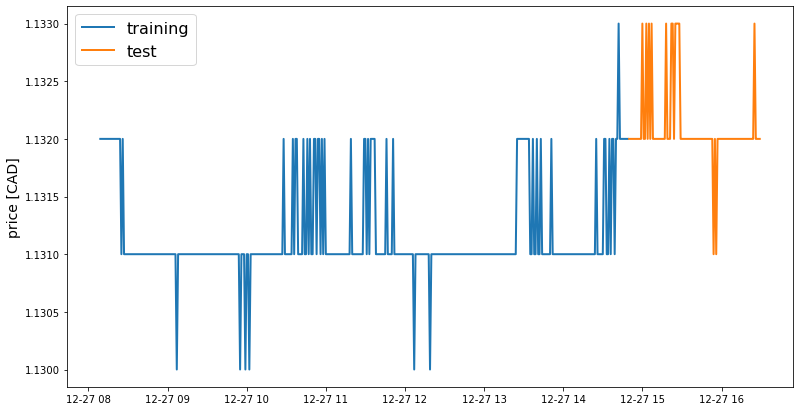

In [7]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [8]:
def normalise_zero_base(df):
    
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    
    return (df - df.min()) / (data.max() - df.min()) 

In [9]:
def extract_window_data(df, window_len=5, zero_base=True):
    
    window_data = []
    
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
        
    return np.array(window_data)

In [10]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    
    if zero_base:
        
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [11]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',dropout=0.2, loss='mse', optimizer='adam'):
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [12]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [13]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [14]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 4s 7ms/step - loss: 0.0205
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 3/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 4/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 5/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 6/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0078
Epoch 7/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0091
Epoch 8/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 9/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0081
Epoch 10/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0084
Epoch 11/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0076
Epoch 12/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0055
Epoch 13/20
13/13 [=========================

In [15]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.017419705824589658

<ipython-input-6-9a75b5629615>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # to see collected data & predicted graph


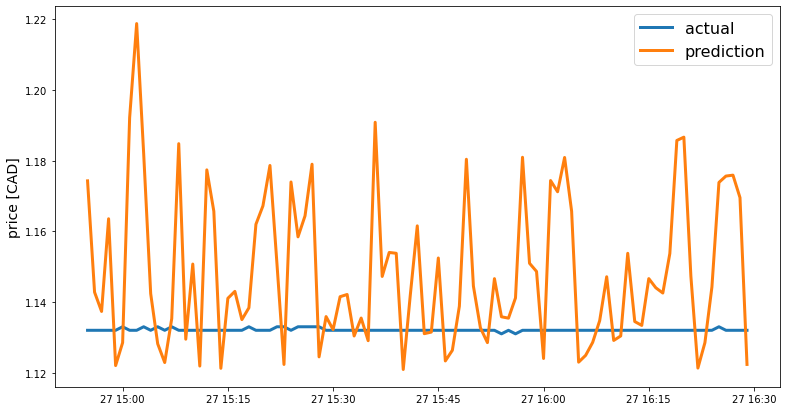

In [16]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)